Update: Increase experiment points

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
from Semi_EM_NB import Semi_EM_MultinomialNB
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [lemmatizer.lemmatize(word.lower(), pos='v') for word in wordlist.split()] # restore word to its root form (lemmatization)
    wordlist_normal = [poster.stem(word) for word in wordlist_normal] # restore word to its original form (stemming)
#     wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [3]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_scores = list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    avg_accuracy = 0
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        scores = dict()
        scores['accuracy'] = metrics.accuracy_score(valid_y, pred)
        scores['recall'] = metrics.recall_score(valid_y, pred, average='macro')
        scores['precision'] = metrics.precision_score(valid_y, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(valid_y, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % (avg_accuracy/n_folds))
    return train_scores, train_time

In [4]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    #d = path.dirname(__file__)
    circle_mask = np.array(Image.open(path.join('./', "circle.png")))
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [5]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:    15076	Test set size:     3770


In [6]:
# preprocess train and test text data
train_X_clean = map(remove_noise, train_X)
test_X_clean = map(remove_noise, test_X)

In [7]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X_clean)
test_vec = vectorizer.transform(test_X_clean)
print train_vec.shape, test_vec.shape

(15076, 13275) (3770, 13275)


In [8]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.2 # labeled vs total(labeled+unlabeled)
# X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, test_size=10000, stratify=train_y)
experiments = np.logspace(2.3, 3.7, num=20, base=10, dtype='int')
print X_l.shape, X_u.shape

(5076, 13275) (10000, 13275)


In [9]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_cv_scores = list()
nb_cv_times = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    cv_scores, cv_time = cross_validation(nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs])
    nb_cv_scores.append(cv_scores)
    nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.172 seconds
Average training accuracy: 0.488
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/home/jerry/Applications/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/jerry/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jerry/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.163 seconds
Average training accuracy: 0.473
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.166 seconds
Average training accuracy: 0.526
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.171 seconds
Average training accuracy: 0.530
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.168 seconds
Average training accuracy: 0.514
Number of labeled documents:    393
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.170 seconds
Average training accuracy: 0.518
Number of labeled documents:

In [10]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_cv_scores = list()
em_nb_cv_times = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
    cv_scores, cv_time = cross_validation(em_nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    em_nb_cv_scores.append(cv_scores)
    em_nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 84.380 seconds
Average training accuracy: 0.612
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 84.189 seconds
Average training accuracy: 0.611
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 77.803 seconds
Average training accuracy: 0.582
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 76.570 seconds
Average training accuracy: 0.618
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Valida

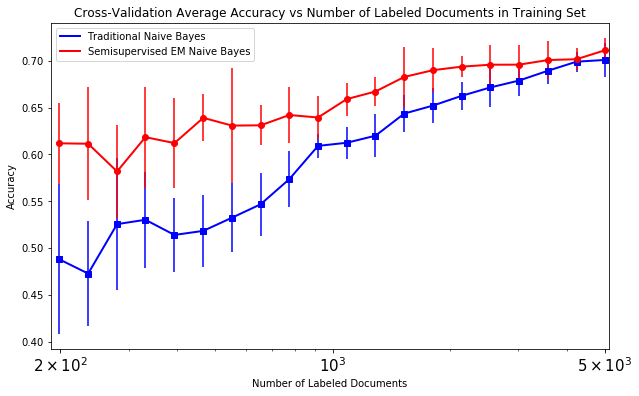

In [11]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['accuracy'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

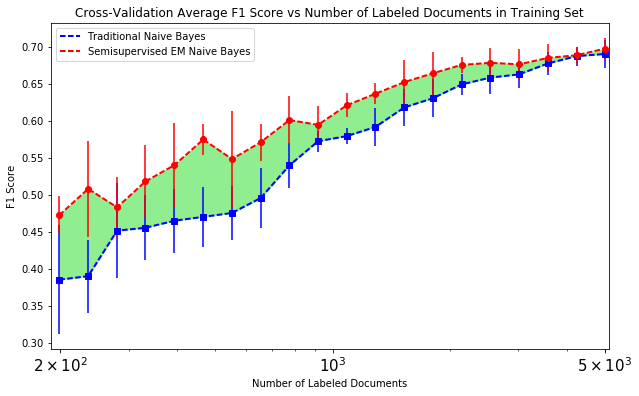

In [12]:
# plot CV F1 Score comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['f1_score'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['f1_score'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average F1 Score vs Number of Labeled Documents in Training Set')

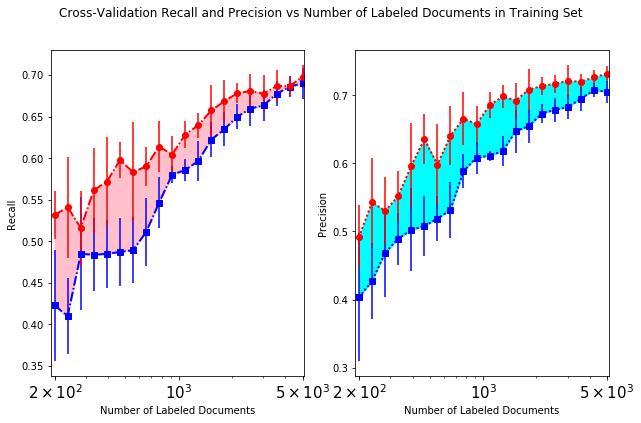

In [13]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['recall'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['recall'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_score_mean, color='b', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax1.plot(experiments, em_nb_score_mean, color='r', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax1.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['precision'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['precision'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_score_mean, color='b', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax2.plot(experiments, em_nb_score_mean, color='r', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax2.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Cross-Validation Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

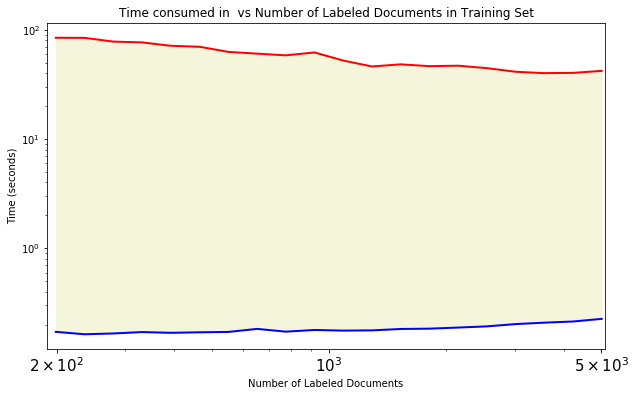

In [14]:
# plot time consuming in EM NB training process
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_cv_times, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_cv_times, color='r', linestyle='-', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.fill_between(experiments, nb_cv_times, em_nb_cv_times, color='beige')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Time (seconds)')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.title('Time consumed in  vs Number of Labeled Documents in Training Set')

In [15]:
# Evaluate original NB classifier using test data set
nb_test_scores = dict()
nb_test_scores['accuracy'] = list()
nb_test_scores['recall'] = list()
nb_test_scores['precision'] = list()
nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2).fit(X_l[:n_l_docs,], y_l[:n_l_docs])
    pred = nb_clf.predict(test_vec)
    accuracy = metrics.accuracy_score(test_y, pred)
    nb_test_scores['accuracy'].append(accuracy)
    nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.430
   236 labeled documents lead to accuracy of 0.453
   280 labeled documents lead to accuracy of 0.476
   331 labeled documents lead to accuracy of 0.493
   393 labeled documents lead to accuracy of 0.513
   466 labeled documents lead to accuracy of 0.527
   552 labeled documents lead to accuracy of 0.541
   654 labeled documents lead to accuracy of 0.555
   775 labeled documents lead to accuracy of 0.575
   918 labeled documents lead to accuracy of 0.588
  1088 labeled documents lead to accuracy of 0.604
  1289 labeled documents lead to accuracy of 0.619
  1528 labeled documents lead to accuracy of 0.627
  1810 labeled documents lead to accuracy of 0.642
  2145 labeled documents lead to accuracy of 0.648
  2542 labeled documents lead to accuracy of 0.659
  3012 labeled documents lead to accuracy of 0.668
  3569 labeled documents lead to accuracy of 0.682
  4229 labeled documents lead to accuracy of 0.686
  5011 labeled documents lead t

In [16]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_test_scores = dict()
em_nb_test_scores['accuracy'] = list()
em_nb_test_scores['recall'] = list()
em_nb_test_scores['precision'] = list()
em_nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False).fit(X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    pred = em_nb_clf.predict(test_vec)
    accuracy = metrics.accuracy_score(test_y, pred)
    em_nb_test_scores['accuracy'].append(accuracy)
    em_nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    em_nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    em_nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.524
   236 labeled documents lead to accuracy of 0.559
   280 labeled documents lead to accuracy of 0.570
   331 labeled documents lead to accuracy of 0.583
   393 labeled documents lead to accuracy of 0.593
   466 labeled documents lead to accuracy of 0.608
   552 labeled documents lead to accuracy of 0.607
   654 labeled documents lead to accuracy of 0.608
   775 labeled documents lead to accuracy of 0.635
   918 labeled documents lead to accuracy of 0.630
  1088 labeled documents lead to accuracy of 0.634
  1289 labeled documents lead to accuracy of 0.651
  1528 labeled documents lead to accuracy of 0.660
  1810 labeled documents lead to accuracy of 0.667
  2145 labeled documents lead to accuracy of 0.679
  2542 labeled documents lead to accuracy of 0.679
  3012 labeled documents lead to accuracy of 0.686
  3569 labeled documents lead to accuracy of 0.696
  4229 labeled documents lead to accuracy of 0.701
  5011 labeled documents lead t

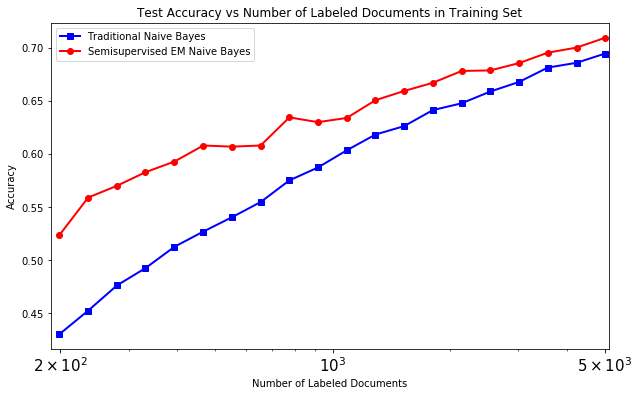

In [17]:
# Plot and compare test accuracy metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['accuracy'], color='b', marker='s', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['accuracy'], color='r', marker='o', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test Accuracy vs Number of Labeled Documents in Training Set')

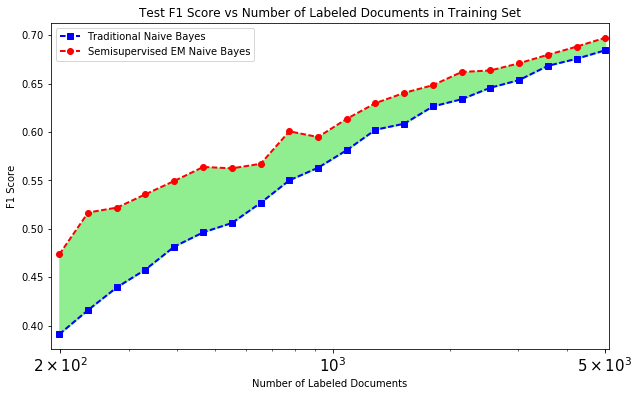

In [18]:
# Plot and compare test f1 score metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['f1_score'], color='b', marker='s', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['f1_score'], color='r', marker='o', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.fill_between(experiments, nb_test_scores['f1_score'], em_nb_test_scores['f1_score'], color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test F1 Score vs Number of Labeled Documents in Training Set')

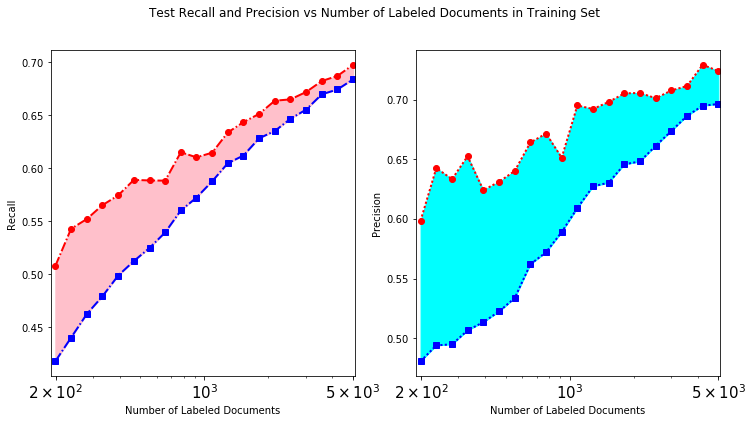

In [19]:
# Plot and compare test recall and precisions metrics
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_test_scores['recall'], color='b', marker='s', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.plot(experiments, em_nb_test_scores['recall'], color='r', marker='o', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.fill_between(experiments, nb_test_scores['recall'], em_nb_test_scores['recall'], color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)

ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_test_scores['precision'], color='b', marker='s', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.plot(experiments, em_nb_test_scores['precision'], color='r', marker='o', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.fill_between(experiments, nb_test_scores['precision'], em_nb_test_scores['precision'], color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Test Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

alt.atheism: muslim argument religi like question read hi becaus belief thing know christian mean delet ani claim make peopl believ islam post exist book think religion say moral atheist thi god
comp.graphics: like hi edu post advanc think gif code packag ftp anim need help softwar work comput pleas convert look anyon know ani format thi program file use thank imag graphic
comp.os.ms-windows.misc: ftp ax print look applic like printer version mail ani manag work os card know disk win microsoft anyon ms program run thank problem font thi driver use file window
comp.sys.ibm.pc.hardware: driver bio comput pleas control pin motherboard need bu run machin know help monitor dx board disk ide mb anyon work problem thank ani pc scsi use thi card drive
comp.sys.mac.hardware: iisi pb powerbook need machin board new power video centri comput intern mb know price work lc card anyon mhz ani thank problem thi monitor simm use appl drive mac
comp.windows.x: look xwd manag librari set sourc know code 

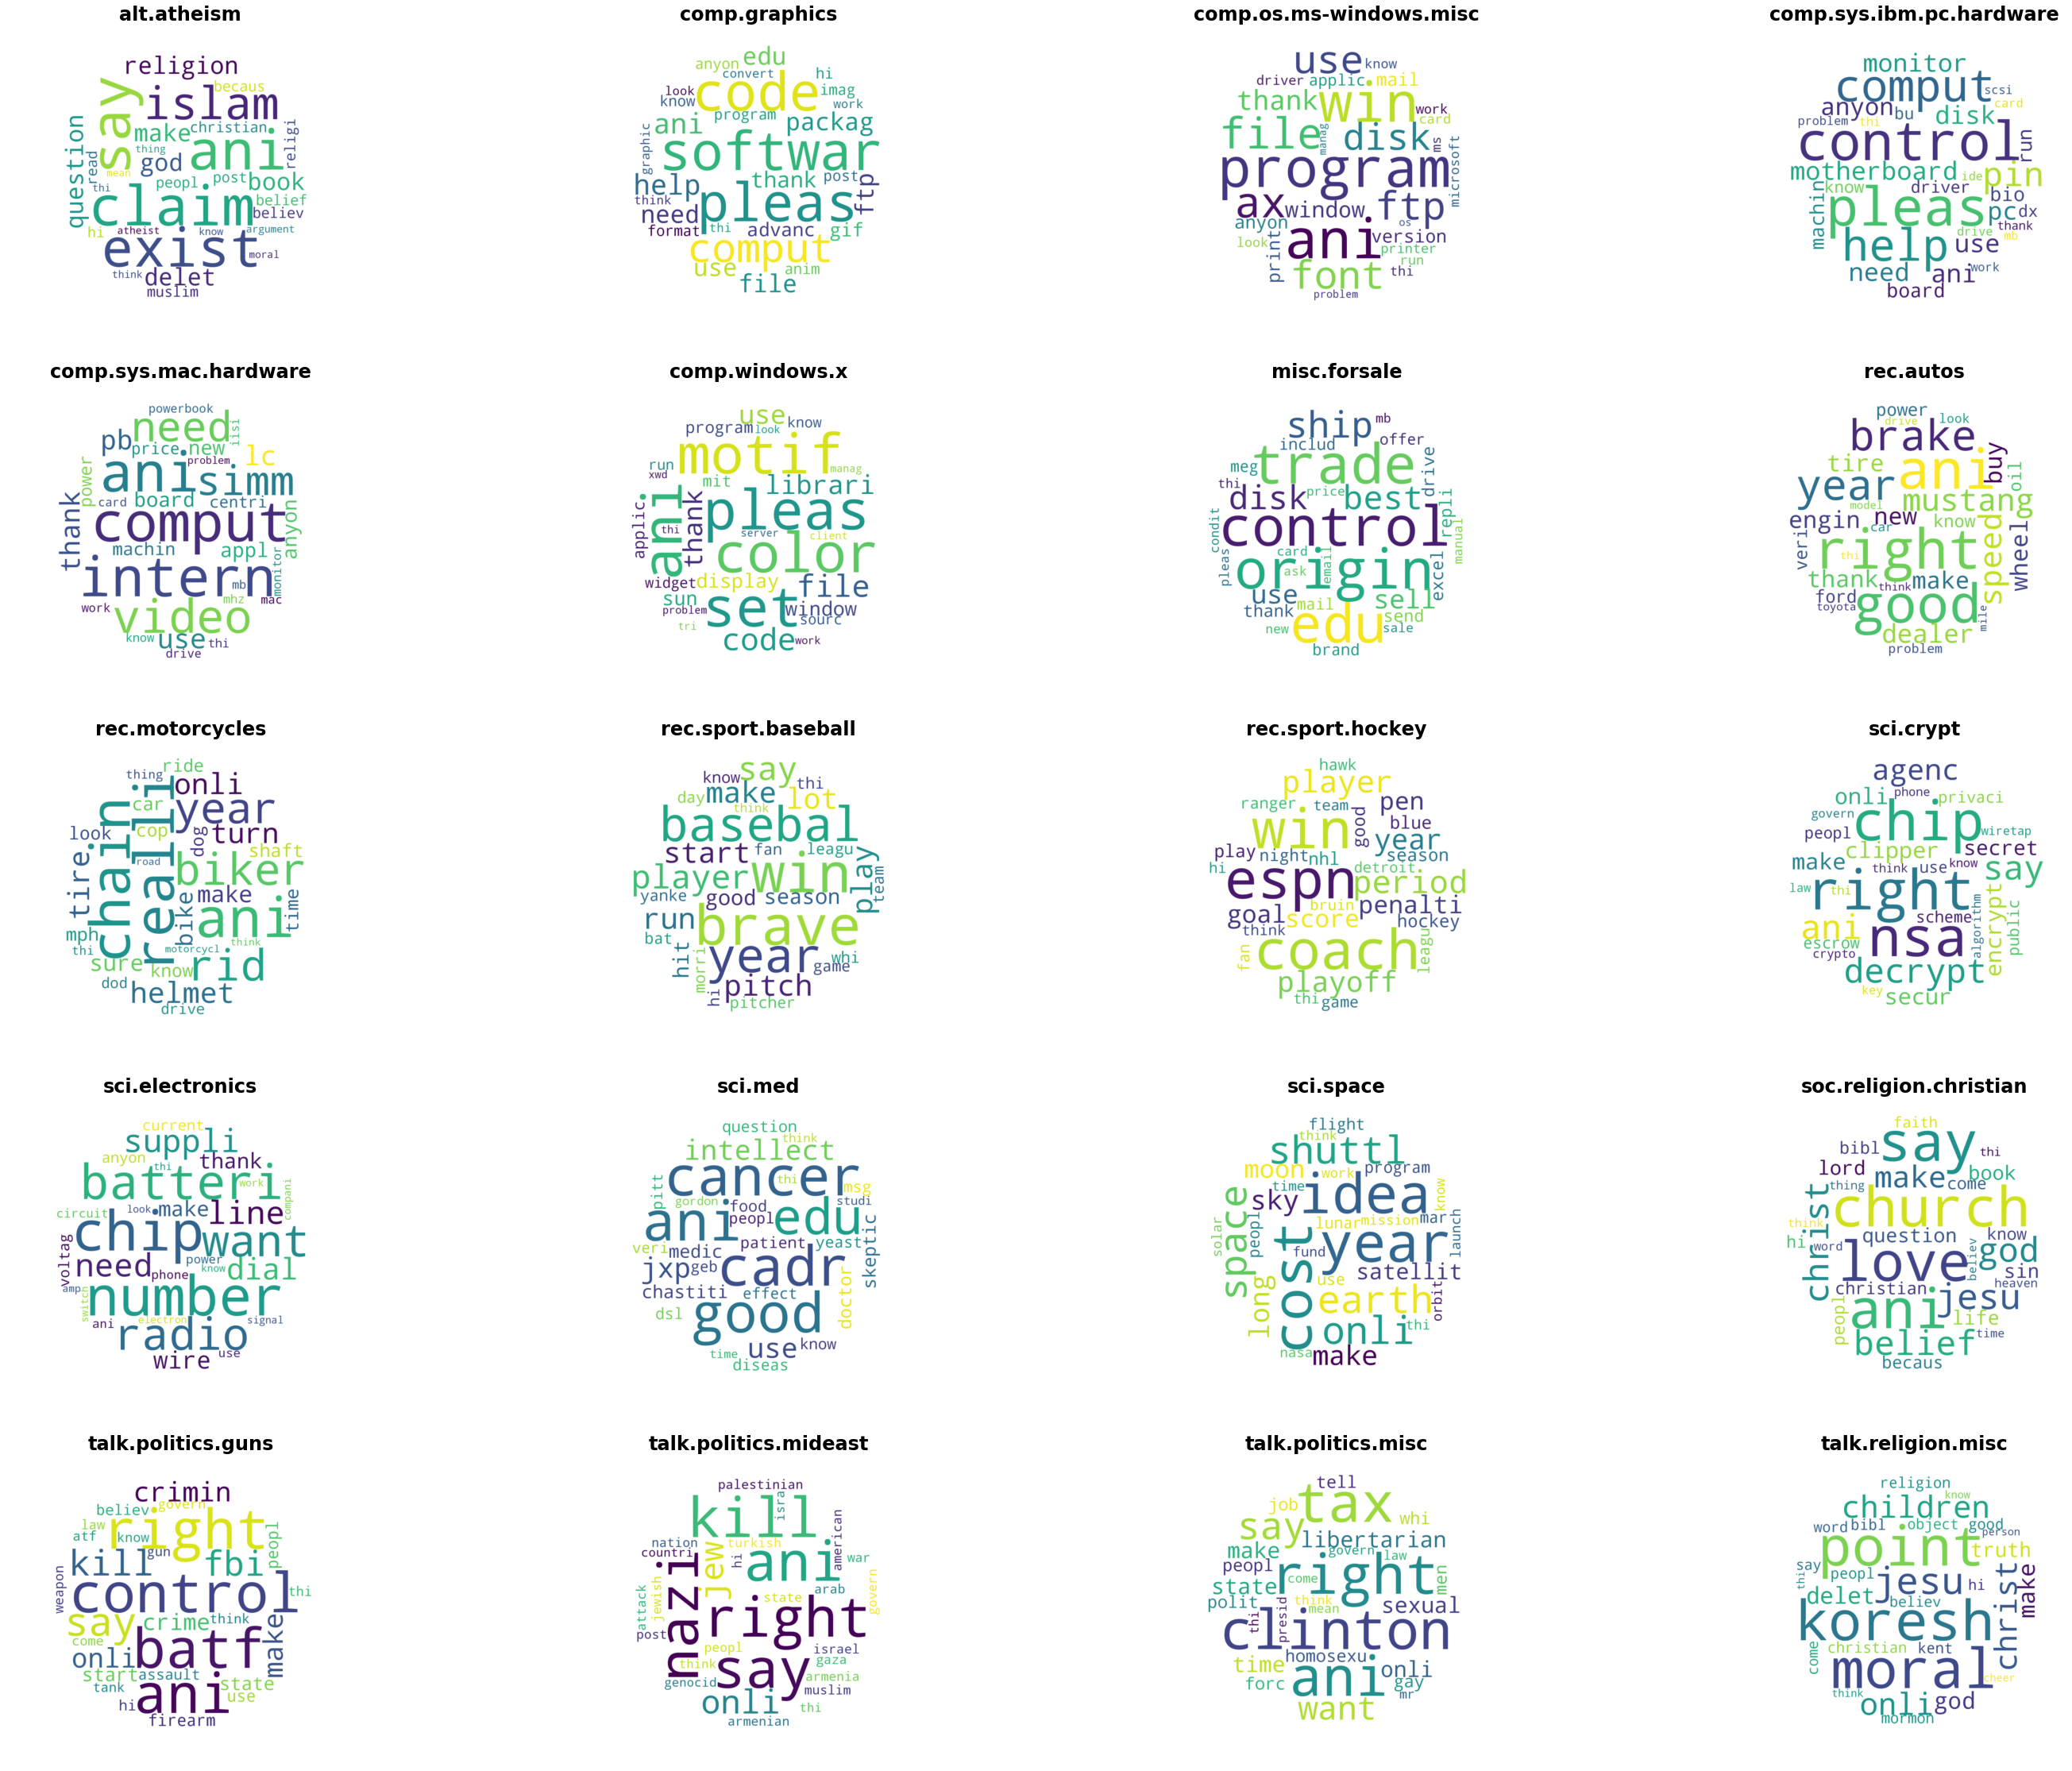

In [20]:
show_topK(nb_clf, vectorizer, category_names, K=30) # keywords for each class by original NB classifier

alt.atheism: becaus natur someth argument human thing whi statement belief know christian make post mean object ani atheism agre claim believ peopl exist islam think religion atheist moral say thi god
comp.graphics: color like bite edu packag advanc need window mail comput inform code convert softwar help gif ftp look pleas anyon know use program format ani thi thank file imag graphic
comp.os.ms-windows.misc: chang like edu cica instal print pc microsoft anyon card work ftp know ms win os disk thank version ani printer font run problem program thi driver use file window
comp.sys.ibm.pc.hardware: com isa buy set run pleas know modem port motherboard work driver board anyon control monitor problem pc thank disk dx ide ani bu mb thi use scsi card drive
comp.sys.mac.hardware: disk video board upgrad buy se duo power price machin comput like quadra anyon lc card centri know work mhz ani thank problem simm monitor use thi drive appl mac
comp.windows.x: look font anyon set help compil like pl

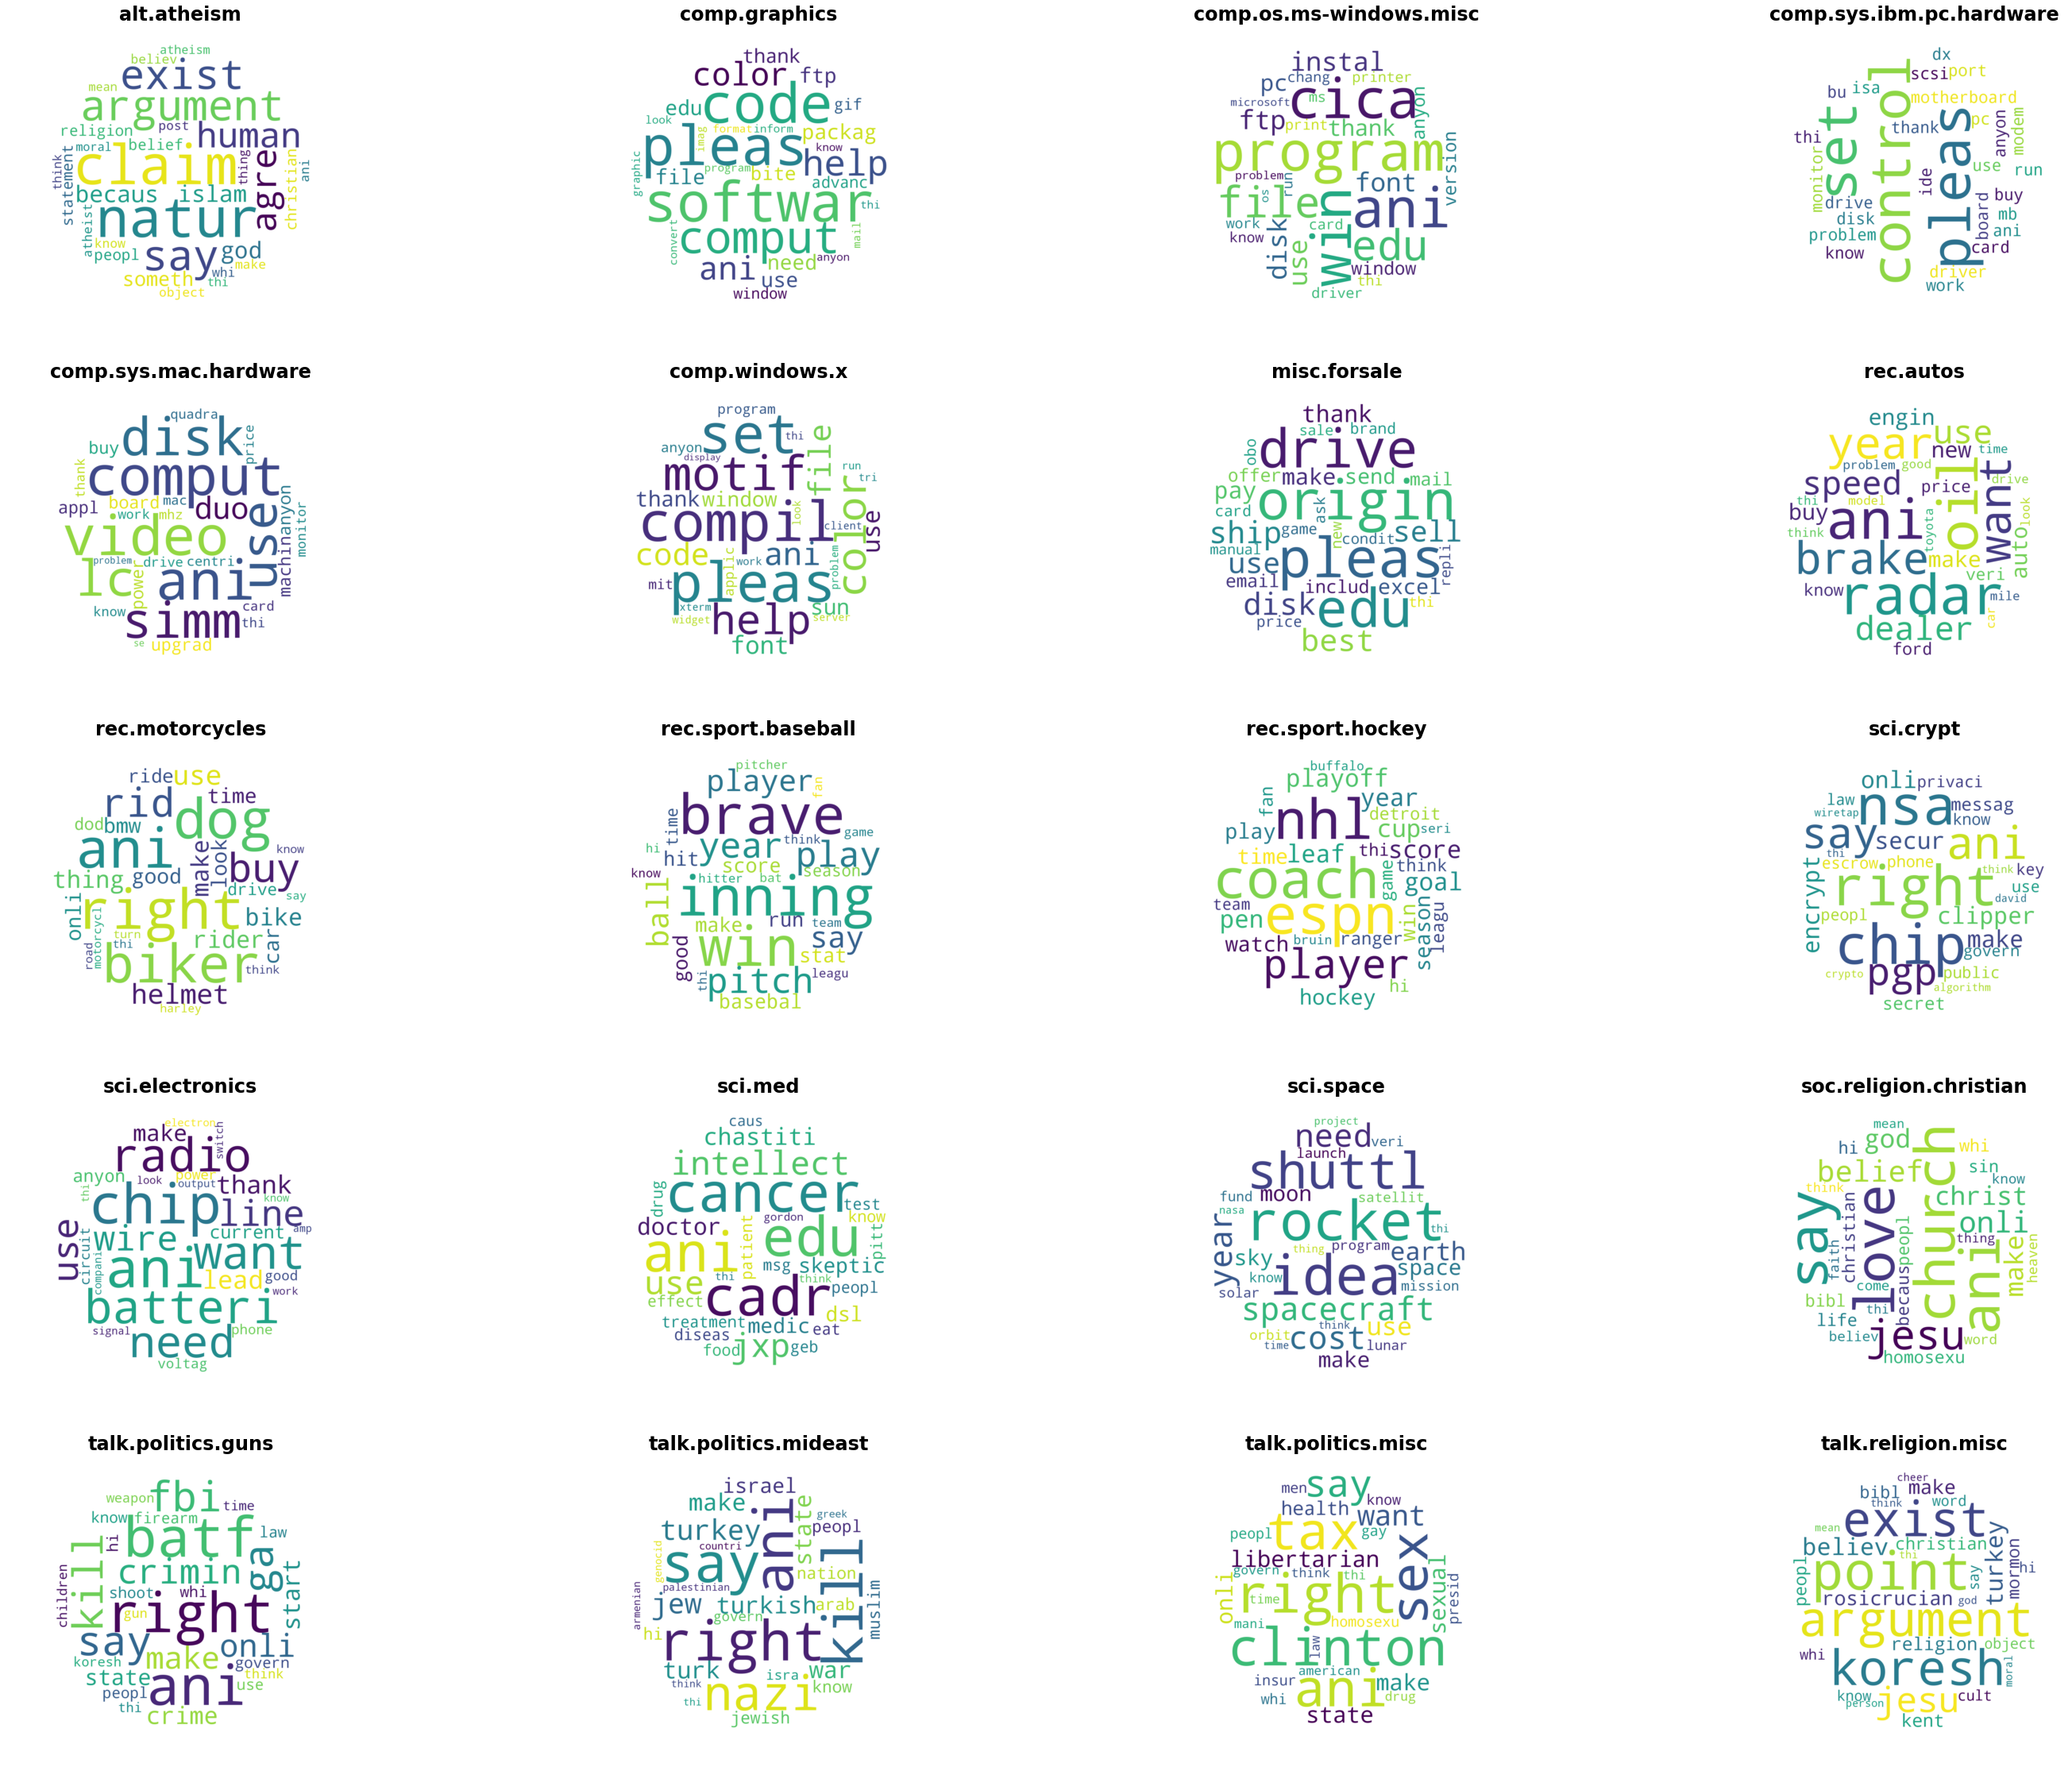

In [21]:
show_topK(em_nb_clf, vectorizer, category_names, K=30) # keywords for each class by semisupervised EM NB classifier